A note book for documenting qualitative results

In [21]:
import os
import matplotlib.pyplot as plt
import torchvision
import torch
import pandas as pd
import numpy as np

from models import get_inception_transform
from data_loaders import CUB_extnded_dataset,CUB_CtoY_dataset
from IPython.display import display
from utils.notebook import display_scrollable_dataframe,plot_sailency
from sailency import get_saliency_maps,saliency_score_part

In [ ]:
# Settings for the experiment your running
data_set = 'test' 

#Make the dataset
transform = get_inception_transform(mode=data_set, methode= "center")

majority_config = {'CUB_dir':r'data/CUB_200_2011',
                'split_file':r'data/train_test_val.pkl',
                'use_majority_voting':True,
                'min_class_count':10,
                'return_visibility':False}

NoN_majority_config = {'CUB_dir':r'data/CUB_200_2011',
                'split_file':r'data/train_test_val.pkl',
                'use_majority_voting':False,
                'min_class_count':10,
                'return_visibility':False}

Non_majority_data_set = CUB_extnded_dataset(mode=data_set,config_dict=NoN_majority_config,transform=transform)

concepts_names = Non_majority_data_set.consept_labels_names

#Make the majority dataset and find the mask, we use CtoY dataset so we only need to loade the image ones 
Majority_dataset = CUB_CtoY_dataset(mode=data_set,config_dict=majority_config,transform=transform)
mask = Majority_dataset.concept_mask

#Make dataloader that return non standarized images
human_tansform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(299),torchvision.transforms.ToTensor()])
data_human = CUB_extnded_dataset(mode=data_set,config_dict=majority_config,transform=human_tansform)

#Define usefull variables
concepts_names = Non_majority_data_set.consept_labels_names
class_names = data_human.class_labels_names
n_classes = data_human.n_classes
n_concepts = data_human.n_concepts

print(f"Number of classes: {n_classes}")
print(f"Number of concepts: {n_concepts}")

Number of classes: 200
Number of concepts: 112


In [23]:
#Find all idx for a class
class_id = 86

class_list = []
for i in range(len(Majority_dataset)):
    C,Y = Majority_dataset.__getitem__(i)
    Y = torch.argmax(Y)
    if Y == class_id:
        class_list.append(i)
print(class_list)





[2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474]


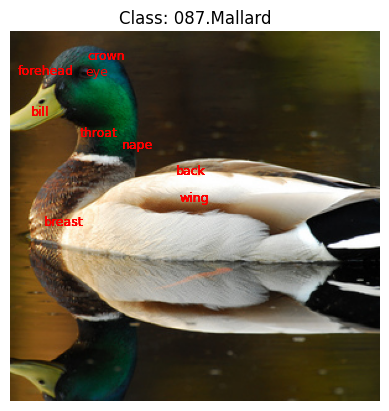

In [35]:
# Genrate the dataset
#picturer_idx = 2455
picturer_idx = 2463
#picturer_idx = 2454 #Gadwell

img ,_,Y,coordinates = data_human.__getitem__(picturer_idx)

# Show the image and the coordinates of the concepts
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Class: {class_names[torch.argmax(Y)]}")
for i in range(len(coordinates)):
    if len(coordinates[i]) > 0:

        for x,y in coordinates[i]:
            #plt.plot(x,y,'ro')
            name=concept_names[i].split("_")[1]
            if name == "forehead":
                ofset = -30

            elif name == "eye":
                ofset = 0
            else:
                ofset = 0
            
            plt.text(x+ofset,y,name,fontsize=9,color='red')
    plt.axis('off')
            
plt.size=(50,50)
plt.show()

#Load the data
X, C, Y,coordinates = Non_majority_data_set.__getitem__(picturer_idx)

# Separate the concepts and their visibility only relevant if visibility is used and no majority voting is used
if len(C.shape) == 2:
    Concepts = C[0]
    Concepts_visiblity = C[1]
else:
    Concepts = C.tolist()
    Concepts_visiblity = [None]*len(C)

X = X.unsqueeze(0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25..0.25].


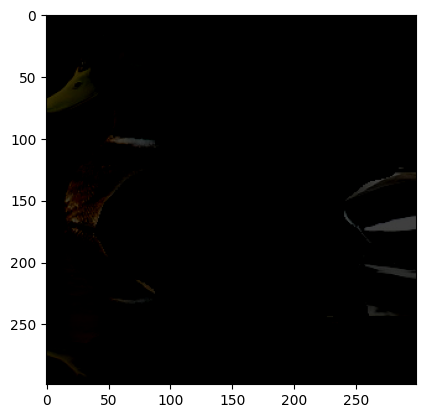

In [36]:
#Load manipulated image
from PIL import Image
X = Image.open("Mallard_Manipulated.jpg")
X = transform(X).unsqueeze(0)

plt.imshow(X[0].permute(1, 2, 0))

In [ ]:
#Make concept dictionary
"""
concept_prediction = concept_prediction[0].detach()
concepts_propebability = torch.sigmoid(concept_prediction)
pridicted_class = Majority_dataset.concepts[Y]
#Apply mask
if concept_prediction.shape != Majority_C.shape:
    concept_prediction = concept_prediction[mask]
    concepts_propebability = concepts_propebability[mask]
"""


#Get ture labels 
_,NoN_Majority_C,_,_ = Non_majority_data_set.__getitem__(picturer_idx)
Majority_C,_ = Majority_dataset.__getitem__(picturer_idx)

#Find distribution of the concepts
Majority_concepts = Majority_dataset.concepts
NoN_Majority_concepts = np.array([Non_majority_data_set.concepts[y] for y in Non_majority_data_set.concepts.keys()])


Concept_dict={"Concept":concept_names[mask],
                    "Label": NoN_Majority_C[mask].numpy().astype(bool),
                    #"Label distribution": np.mean(NoN_Majority_concepts,axis=0)[mask],
                    "Majority Label": Majority_C.numpy().astype(bool),
                    #"Majority ditribution": np.mean(Majority_concepts,axis=0)
                      }
    


  

In [41]:
#Test majority joint model
model_path = r'Majority_models\Joint_CKPT_Majority\best_Joint_model.pth'

#Load the model
Joint_model = torch.load(model_path,map_location=torch.device('cpu'),weights_only=False)
Joint_model.eval()
Joint_model.use_sigmoid = True

#Make prediction
C_hat,Y_hat = Joint_model(X)
C_hat_probability = torch.sigmoid(C_hat)
Y_hat = torch.softmax(Y_hat,dim=1)
print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")

#Make Concept prediction and other stuff
weights = Joint_model.CtoY_model.linear.weight[Y.argmax().item()]
Concept_dict["Joint MV"] = np.round(C_hat_probability.detach().numpy()[0],2)
#display_scrollable_dataframe(pd.DataFrame(Concept_dict))

Predicted class: 087.Mallard true class: 087.Mallard probability of true class: 0.010462581180036068


In [42]:
#Test NoN majority joint model
model_path = r'NoMajority_models\Joint_CKPT_NoMajority\best_Joint_model.pth'

#Load the model
Joint_model = torch.load(model_path,map_location=torch.device('cpu'),weights_only=False)
Joint_model.eval()
Joint_model.use_sigmoid = True

#Make prediction
C_hat,Y_hat = Joint_model(X)
C_hat_probability = torch.sigmoid(C_hat)
Y_hat = torch.softmax(Y_hat,dim=1)
print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")

#Make Concept prediction and other stuff
weights = Joint_model.CtoY_model.linear.weight[Y.argmax().item()]
Concept_dict["Joint NoN-MV"] = np.round(C_hat_probability.detach().numpy()[0][mask],2)
#display_scrollable_dataframe(pd.DataFrame(Concept_dict).sort_values(by=['Joint NonMajority prediction'],ascending=False))

Predicted class: 087.Mallard true class: 087.Mallard probability of true class: 0.011868683621287346


In [43]:
# Test the concept model with majority voting
XtoC_Model = torch.load(r'evaluate_models\Concepts_CKPT_Majority\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()

CtoY_Model = torch.load(r'evaluate_models\Sequential_Majority_end\best_CtoY_model.pth',map_location=torch.device('cpu'),weights_only=False)
CtoY_Model.eval()
CtoY_model = CtoY_Model.float()

#Make prediction
C_hat = XtoC_Model(X)
C_hat_probability = torch.sigmoid(C_hat)

Y_hat = torch.softmax(CtoY_Model(C_hat_probability),dim=1)

print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")

#Make Concept prediction and other stuff
weights = CtoY_Model.linear.weight[Y.argmax().item()]

Concept_dict["Sequential MV"] = np.round(C_hat_probability.detach().numpy()[0],2)
#display_scrollable_dataframe(pd.DataFrame(Concept_dict).sort_values(by=['Majority Label',"Label"],ascending=False))





Predicted class: 087.Mallard true class: 087.Mallard probability of true class: 0.9995294809341431


In [44]:
# Test the concept model with NoN majority voting
XtoC_Model = torch.load(r'evaluate_models\Concepts_CKPT_NoMajority\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()

CtoY_Model = torch.load(r'evaluate_models\Sequntial_NoMajority_end\best_CtoY_model.pth',map_location=torch.device('cpu'),weights_only=False)
CtoY_Model.eval()
CtoY_model = CtoY_Model.float()

#Make prediction
C_hat = XtoC_Model(X)
C_hat_probability = torch.sigmoid(C_hat)

Y_hat = torch.softmax(CtoY_Model(C_hat_probability),dim=1)

print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")

#Make Concept prediction and other stuff
weights = CtoY_Model.linear.weight[Y.argmax().item()]

Concept_dict["Sequential NoN-MV"] = np.round(C_hat_probability.detach().numpy()[0][mask],2)
#display_scrollable_dataframe(pd.DataFrame(Concept_dict).sort_values(by=['Majority Label',"Label"],ascending=False))

Predicted class: 087.Mallard true class: 087.Mallard probability of true class: 1.0


In [45]:
#Add the baslines
Concept_dict["NoN-MV Label distribution"] = np.mean(NoN_Majority_concepts,axis=0)[mask]
Concept_dict["MV label ditribution"] = np.mean(Majority_concepts,axis=0)


In [46]:
Full_df=pd.DataFrame(Concept_dict)
Selected_df = Full_df[Full_df["Label"] != Full_df["Majority Label"]]

# add row 39 to selected
#Selected_df = pd.concat([Selected_df,Full_df.iloc[[39,8,51]]])

display_scrollable_dataframe(Selected_df)

,Concept,Label,Majority Label,Joint MV,Joint NoN-MV,Sequential MV,Sequential NoN-MV,NoN-MV Label distribution,MV label ditribution
4,has_wing_color::brown,True,False,0.0,0.52,0.00,0.33,0.269681,0.245
9,has_wing_color::buff,True,False,0.0,0.35,0.00,0.19,0.182474,0.130
10,has_upperparts_color::brown,False,True,1.0,0.56,1.00,0.34,0.243468,0.230
13,has_upperparts_color::black,True,False,0.0,0.49,0.01,0.45,0.391245,0.410
22,has_breast_pattern::solid,False,True,1.0,0.49,1.00,0.43,0.548269,0.645
23,has_breast_pattern::striped,True,False,0.0,0.06,0.00,0.07,0.117153,0.075
29,has_back_color::white,True,False,0.0,0.40,0.00,0.11,0.153800,0.120
30,has_back_color::buff,True,False,0.0,0.37,0.00,0.20,0.146335,0.110
35,has_upper_tail_color::white,True,False,0.0,0.24,0.00,0.25,0.123940,0.120
50,has_eye_color::black,False,True,1.0,0.89,1.00,0.94,0.837462,0.960


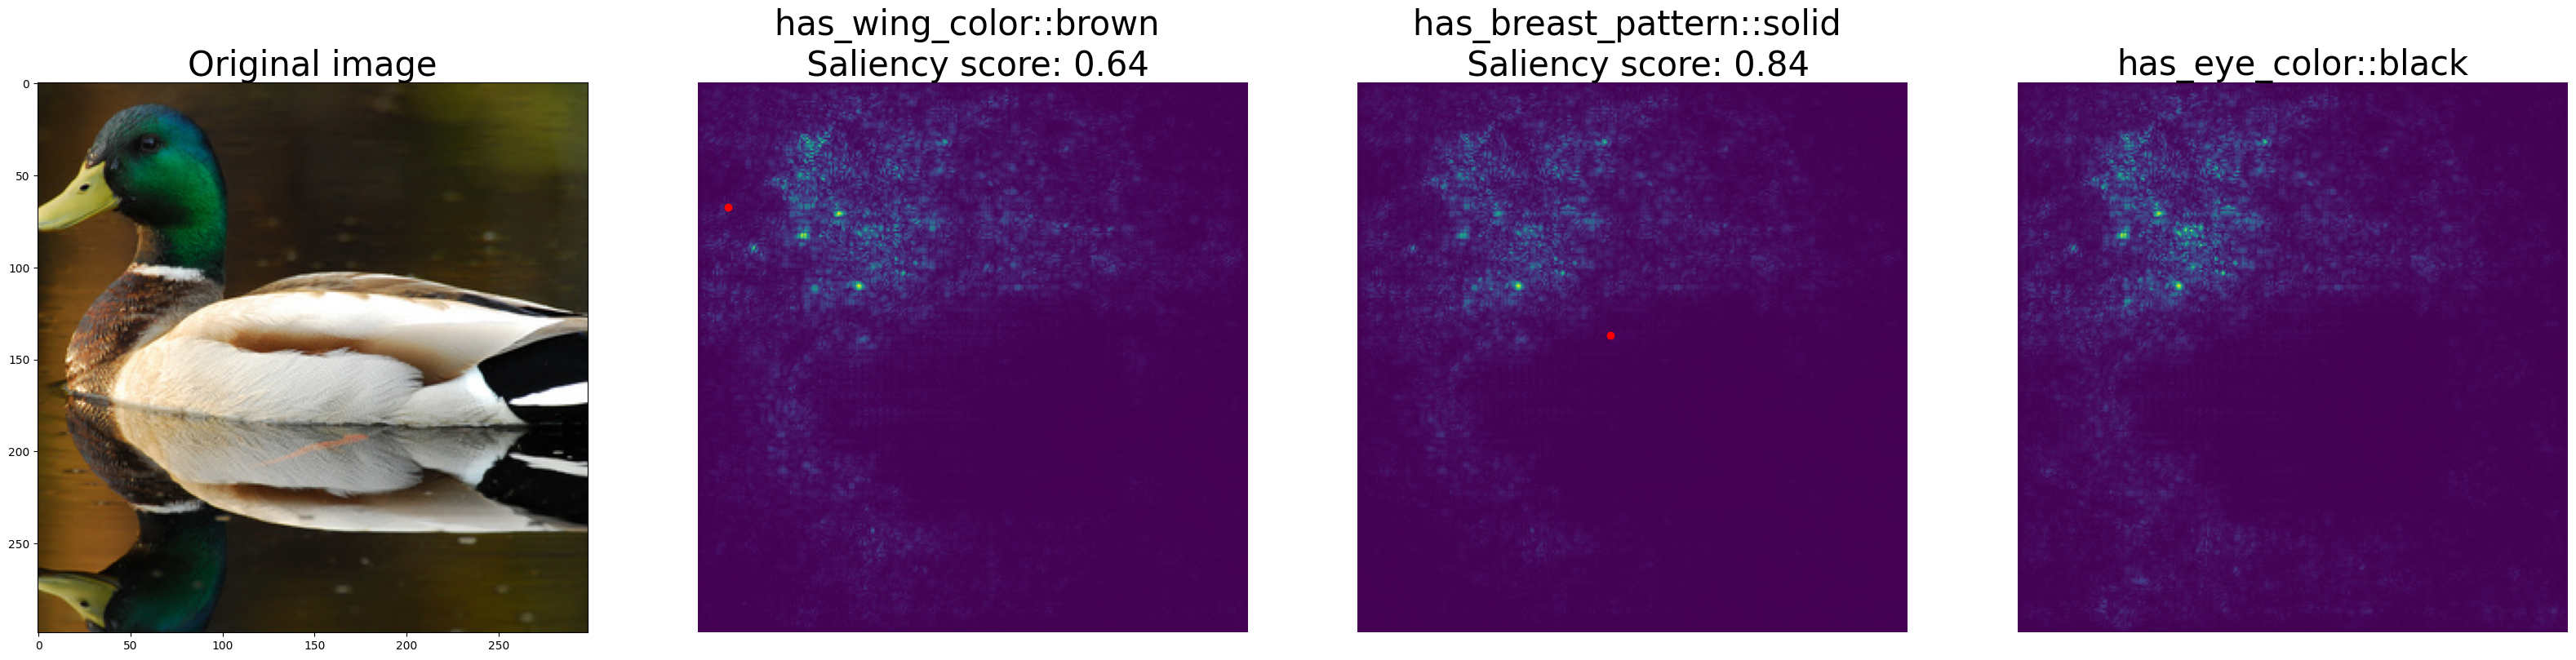

In [53]:
concept_list = [4,22,50]

XtoC_Model = torch.load(r'Majority_models\Concepts_CKPT_Majority\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()
sailency_maps = get_saliency_maps(X,concept_list,XtoC_Model,method_type="vanilla")#'noise_tunnel')

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

In [55]:
len(coordinates)

312

In [54]:

XtoC_Model = torch.load(r'NoMajority_models\Concepts_CKPT_NoMajority\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()

#Make temps names
coordinates_temp = [coordinates[i] for i in mask]
concept_names_temp = concept_names[mask] 
sailency_maps = get_saliency_maps(X,concept_list,XtoC_Model,method_type="vanilla")#'noise_tunnel'))

plot_sailency(img,sailency_maps,concept_list,concept_names_temp,concept_names_temp)

IndexError: index 116 is out of bounds for axis 0 with size 112

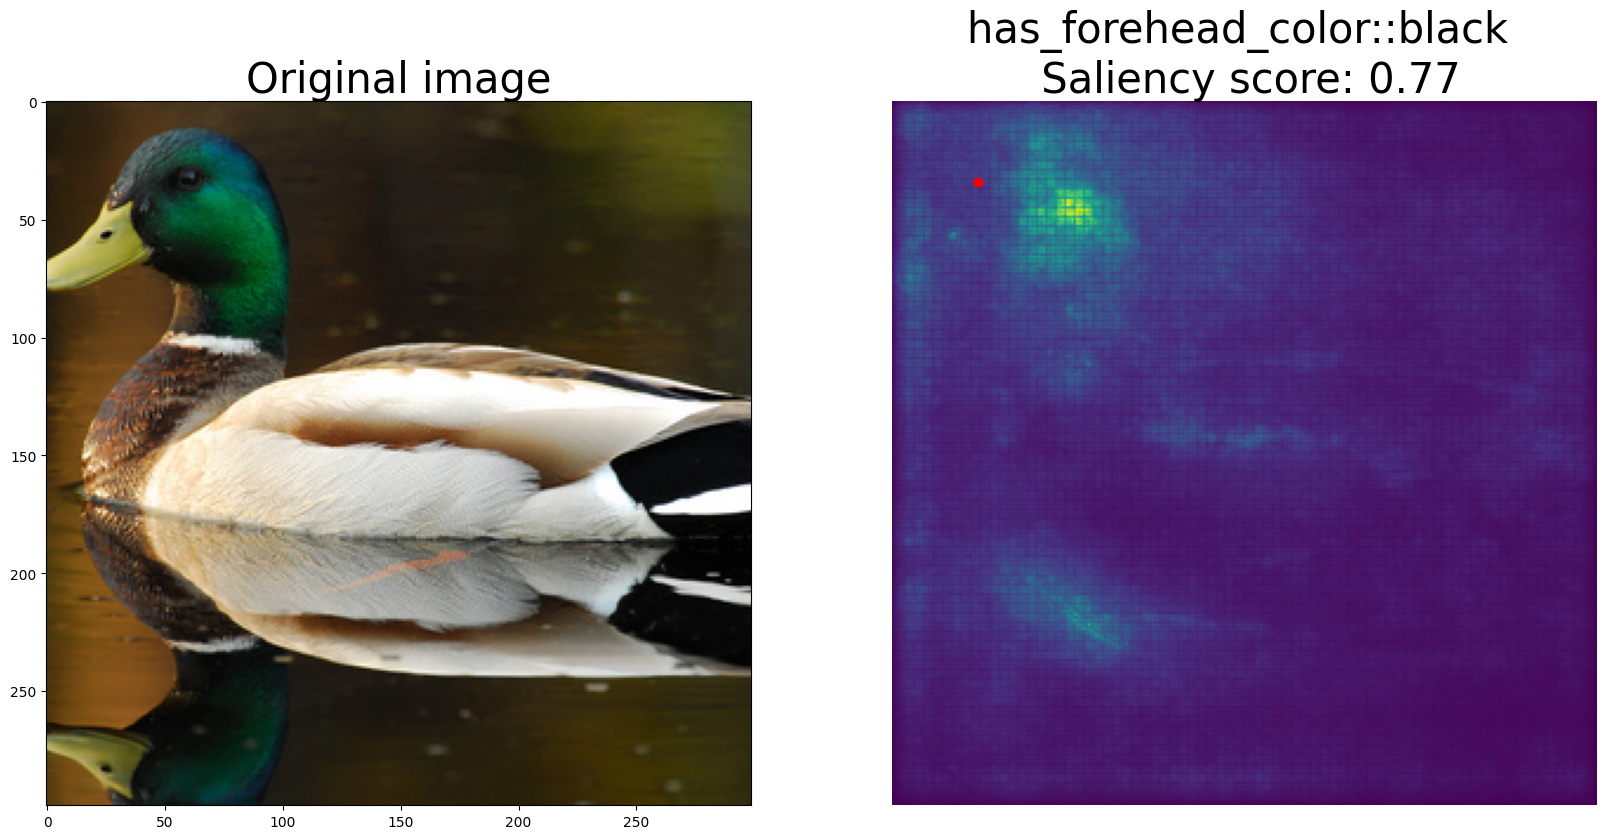

In [ ]:
concept_list = [57]
XtoC_Model = torch.load(r'evaluate_models\Concepts_CKPT_NoMajority\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()
sailency_maps = get_saliency_maps(X,concept_list,XtoC_Model,method_type='noise_tunnel')

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

In [ ]:
#print full df
display_scrollable_dataframe(Full_df.sort_values(by=['Majority Label',"Label"],ascending=False))

,Concept,Label,Majority Label,Joint MV,Joint NoN-MV,Sequential MV,Sequential NoN-MV,NoN-MV Label distribution,MV label ditribution
8,has_wing_color::white,True,True,1.0,0.97,1.0,0.85,0.260774,0.205
14,has_upperparts_color::white,True,True,1.0,0.93,1.0,0.80,0.232949,0.175
15,has_upperparts_color::buff,True,True,1.0,0.78,1.0,0.74,0.169410,0.125
16,has_underparts_color::brown,True,True,1.0,0.53,1.0,0.78,0.102732,0.060
34,has_upper_tail_color::black,True,True,1.0,0.63,1.0,0.68,0.256956,0.305
38,has_head_pattern::plain,True,True,1.0,0.66,1.0,0.92,0.263828,0.215
39,has_breast_color::brown,True,True,1.0,0.93,1.0,0.99,0.113590,0.065
51,has_bill_length::about_the_same_as_head,True,True,1.0,0.67,1.0,0.85,0.362233,0.340
79,has_size::medium_(9_-_16_in),True,True,1.0,0.98,1.0,0.98,0.196386,0.185
81,has_shape::duck-like,True,True,1.0,0.98,1.0,0.98,0.061334,0.050


In [ ]:
print(Selected_df.to_latex(index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
Concept & Label & Majority Label & Joint MV & Joint NoN-MV & Sequential MV & Sequential NoN-MV & NoN-MV Label distribution & MV label ditribution \\
\midrule
has_wing_color::brown & True & False & 0.000000 & 0.620000 & 0.000000 & 0.570000 & 0.269681 & 0.245000 \\
has_wing_color::buff & True & False & 0.000000 & 0.450000 & 0.000000 & 0.470000 & 0.182474 & 0.130000 \\
has_upperparts_color::brown & False & True & 1.000000 & 0.640000 & 1.000000 & 0.670000 & 0.243468 & 0.230000 \\
has_upperparts_color::black & True & False & 0.000000 & 0.540000 & 0.000000 & 0.630000 & 0.391245 & 0.410000 \\
has_breast_pattern::solid & False & True & 1.000000 & 0.490000 & 1.000000 & 0.380000 & 0.548269 & 0.645000 \\
has_breast_pattern::striped & True & False & 0.000000 & 0.010000 & 0.000000 & 0.050000 & 0.117153 & 0.075000 \\
has_back_color::white & True & False & 0.000000 & 0.680000 & 0.000000 & 0.280000 & 0.153800 & 0.120000 \\
has_back_color::buff & True & False & 0.000

In [ ]:
display_scrollable_dataframe(Full_df.sort_values(by=['Majority Label',"Label"],ascending=False))

,Concept,Label,Majority Label,Joint MV,Joint NoN-MV,Sequential MV,Sequential NoN-MV,NoN-MV Label distribution,MV label ditribution
8,has_wing_color::white,True,True,1.0,0.97,1.0,0.85,0.260774,0.205
14,has_upperparts_color::white,True,True,1.0,0.93,1.0,0.80,0.232949,0.175
15,has_upperparts_color::buff,True,True,1.0,0.78,1.0,0.74,0.169410,0.125
16,has_underparts_color::brown,True,True,1.0,0.53,1.0,0.78,0.102732,0.060
34,has_upper_tail_color::black,True,True,1.0,0.63,1.0,0.68,0.256956,0.305
38,has_head_pattern::plain,True,True,1.0,0.66,1.0,0.92,0.263828,0.215
39,has_breast_color::brown,True,True,1.0,0.93,1.0,0.99,0.113590,0.065
51,has_bill_length::about_the_same_as_head,True,True,1.0,0.67,1.0,0.85,0.362233,0.340
79,has_size::medium_(9_-_16_in),True,True,1.0,0.98,1.0,0.98,0.196386,0.185
81,has_shape::duck-like,True,True,1.0,0.98,1.0,0.98,0.061334,0.050


In [ ]:
df=pd.DataFrame(Concept_dict).sort_values(by=['Majority Label',"Label"],ascending=False)
latex_table = df.to_latex(index=False)
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
Concept & Label & Majority Label & Joint MV & Joint NoN-MV & Sequential MV & Sequential NoN-MV & NoN-MV Label distribution & MV label ditribution \\
\midrule
has_wing_color::white & True & True & 1.000000 & 0.970000 & 1.000000 & 0.850000 & 0.260774 & 0.205000 \\
has_upperparts_color::white & True & True & 1.000000 & 0.930000 & 1.000000 & 0.800000 & 0.232949 & 0.175000 \\
has_upperparts_color::buff & True & True & 1.000000 & 0.780000 & 1.000000 & 0.740000 & 0.169410 & 0.125000 \\
has_underparts_color::brown & True & True & 1.000000 & 0.530000 & 1.000000 & 0.780000 & 0.102732 & 0.060000 \\
has_upper_tail_color::black & True & True & 1.000000 & 0.630000 & 1.000000 & 0.680000 & 0.256956 & 0.305000 \\
has_head_pattern::plain & True & True & 1.000000 & 0.660000 & 1.000000 & 0.920000 & 0.263828 & 0.215000 \\
has_breast_color::brown & True & True & 1.000000 & 0.930000 & 1.000000 & 0.990000 & 0.113590 & 0.065000 \\
has_bill_length::about_the_same_as_head & Tr